<a href="https://colab.research.google.com/github/KarinaRmzG/Neuronal-Networks/blob/main/EVC_H_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importa bibliotecas del sistema
import os
import itertools

# Importa herramientas para el manejo de datos
import cv2  # OpenCV para procesamiento de imágenes
import numpy as np  # NumPy para operaciones matriciales eficientes
import pandas as pd  # Pandas para análisis y manipulación de datos
import seaborn as sns  # Seaborn para visualización estadística
sns.set_style('darkgrid')  # Configura el estilo de Seaborn a 'darkgrid'
import matplotlib.pyplot as plt  # Matplotlib para gráficos y visualizaciones
from sklearn.model_selection import train_test_split  # scikit-learn para división de conjuntos de datos

# Importa bibliotecas de aprendizaje profundo
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import confusion_matrix, classification_report

# Ignora las advertencias durante la ejecución
import warnings
warnings.filterwarnings("ignore")

# Imprime un mensaje indicando que los módulos han sido cargados
print('modules loaded')

modules loaded


In [ ]:
# Función para definir rutas de archivos y etiquetas a partir de un directorio dado
def define_paths(dir):
    """
    Parameters:
        dir (str): Ruta del directorio principal que contiene subdirectorios para diferentes clases.

    Returns:
        filepaths (list): Lista de rutas completas de archivos.
        labels (list): Lista de etiquetas correspondientes a cada archivo.
    """
    filepaths = []
    labels = []

    # Obtiene la lista de subdirectorios en el directorio principal
    folds = os.listdir(dir)

    # Itera sobre cada subdirectorio
    for fold in folds:
        foldpath = os.path.join(dir, fold)

        # Obtiene la lista de archivos en el subdirectorio actual
        filelist = os.listdir(foldpath)

        # Itera sobre cada archivo en el subdirectorio actual
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            # Agrega la ruta del archivo y su etiqueta a las listas correspondientes
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels

# Función para definir un DataFrame a partir de listas de rutas de archivos y etiquetas
def define_df(files, classes):
    """
    Parameters:
        files (list): Lista de rutas completas de archivos.
        classes (list): Lista de etiquetas correspondientes a cada archivo.

    Returns:
        DataFrame: Pandas DataFrame que contiene columnas 'filepaths' y 'labels'.
    """
    # Crea series de Pandas a partir de las listas de archivos y clases
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')

    # Concatena las series en un DataFrame
    return pd.concat([Fseries, Lseries], axis=1)

# Función para crear DataFrames para conjuntos de entrenamiento, validación y prueba
def create_df(tr_dir, val_dir, ts_dir):
    """
    Parameters:
        tr_dir (str): Ruta del directorio de entrenamiento.
        val_dir (str): Ruta del directorio de validación.
        ts_dir (str): Ruta del directorio de prueba.

    Returns:
        train_df (DataFrame): DataFrame para el conjunto de entrenamiento.
        valid_df (DataFrame): DataFrame para el conjunto de validación.
        test_df (DataFrame): DataFrame para el conjunto de prueba.
    """
    # DataFrame de entrenamiento
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    # DataFrame de validación
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)

    # DataFrame de prueba
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)

    return train_df, valid_df, test_df

In [ ]:
def create_gens(train_df, valid_df, test_df, batch_size):
    """
    Crea generadores de imágenes para conjuntos de entrenamiento, validación y prueba.

    Parameters:
        train_df (DataFrame): DataFrame para el conjunto de entrenamiento.
        valid_df (DataFrame): DataFrame para el conjunto de validación.
        test_df (DataFrame): DataFrame para el conjunto de prueba.
        batch_size (int): Tamaño del lote para los generadores de entrenamiento y validación.

    Returns:
        train_gen (DirectoryIterator): Generador de imágenes para el conjunto de entrenamiento.
        valid_gen (DirectoryIterator): Generador de imágenes para el conjunto de validación.
        test_gen (DirectoryIterator): Generador de imágenes para el conjunto de prueba.
    """
    # Configuración de dimensiones de imágenes y canales
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)

    # Determinar el tamaño de lote para el conjunto de prueba
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
    test_steps = ts_length // test_batch_size

    # Función escalar para preprocesamiento
    def scalar(img):
        return img

    # Configuración de generadores de imágenes para entrenamiento, validación y prueba
    tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    # Generador de imágenes para conjunto de entrenamiento
    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                          class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

    # Generador de imágenes para conjunto de validación
    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                          class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

    # Generador de imágenes para conjunto de prueba
    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                         class_mode='categorical', color_mode='rgb', shuffle=False,
                                         batch_size=test_batch_size)

    return train_gen, valid_gen, test_gen

La función "show_images" toma un generador de imágenes de Keras como entrada y muestra visualmente un lote de imágenes junto con sus etiquetas correspondientes. La visualización se organiza en una cuadrícula de 5x5. Las imágenes se escalan al rango (0 - 255) y se muestra el nombre de la clase en azul como título debajo de cada imagen. La función utiliza la información del generador para mapear los índices de clases a nombres de clases.

In [ ]:
def show_images(gen):
    """
    Muestra visualmente un lote de imágenes junto con sus etiquetas.

    Parameters:
        gen (DirectoryIterator): Generador de imágenes de Keras.

    Returns:
        None
    """
    # Obtiene el diccionario de índices de clases del generador
    g_dict = gen.class_indices

    # Obtiene la lista de nombres de clases a partir de los índices
    classes = list(g_dict.keys())

    # Obtiene un lote de imágenes y etiquetas del generador
    images, labels = next(gen)

    # Configura la visualización en una cuadrícula de 5x5
    plt.figure(figsize=(20, 20))

    # Determina la longitud del lote
    length = len(labels)

    # Define el número máximo de imágenes a mostrar (máximo 25)
    sample = min(length, 25)

    # Itera sobre el lote y muestra las imágenes con sus etiquetas
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255  # Escala los datos al rango (0 - 255)
        plt.imshow(image)

        # Obtiene el índice de la etiqueta con el valor máximo (predicción de clase)
        index = np.argmax(labels[i])

        # Obtiene el nombre de la clase correspondiente al índice
        class_name = classes[index]

        # Agrega el título con el nombre de la clase en azul
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')

    # Muestra la visualización
    plt.show()

La función "plot_training" toma un objeto History generado durante el entrenamiento de un modelo con Keras y visualiza las curvas de entrenamiento y validación a lo largo de las épocas. La función muestra gráficas de pérdida y precisión tanto para el conjunto de entrenamiento como para el de validación. Además, destaca el punto de la menor pérdida de validación y el punto de la mayor precisión de validación en las respectivas gráficas.

In [ ]:
def plot_training(hist):
    """
    Visualiza las curvas de entrenamiento y validación de un modelo a lo largo de las épocas.

    Parameters:
        hist (History): Objeto History generado durante el entrenamiento de un modelo con Keras.

    Returns:
        None
    """
    # Extrae las métricas de entrenamiento y validación del historial
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    # Encuentra el número de época con la menor pérdida de validación
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    # Encuentra el número de época con la mayor precisión de validación
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    # Configura la figura y el estilo
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    # Crea un eje para la pérdida
    plt.subplot(1, 2, 1)
    Epochs = [i + 1 for i in range(len(tr_acc))]  # Eje x por número de época
    loss_label = f'best epoch= {str(index_loss + 1)}'  # Etiqueta de la menor pérdida de validación
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Crea un eje para la precisión
    plt.subplot(1, 2, 2)
    acc_label = f'best epoch= {str(index_acc + 1)}'  # Etiqueta de la mayor precisión de validación
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Ajusta el diseño y muestra la figura
    plt.tight_layout
    plt.show()

La función "plot_confusion_matrix" toma una matriz de confusión, una lista de nombres de clases y algunos parámetros opcionales para visualizar la matriz de confusión. La matriz de confusión puede ser normalizada o no. La función utiliza la biblioteca Matplotlib para crear una visualización de la matriz de confusión, mostrando las etiquetas reales y predichas. Además, indica si la matriz de confusión ha sido normalizada o no, y muestra los valores numéricos en cada celda de la matriz.

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Visualiza una matriz de confusión.

    Parameters:
        cm (array-like): Matriz de confusión.
        classes (list): Lista de nombres de clases.
        normalize (bool): Indica si la matriz de confusión debe ser normalizada.
        title (str): Título de la figura.
        cmap (matplotlib colormap): Mapa de colores para la visualización.

    Returns:
        None
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Found 1843 validated image filenames belonging to 2 classes.
Found 235 validated image filenames belonging to 2 classes.
Found 437 validated image filenames belonging to 2 classes.


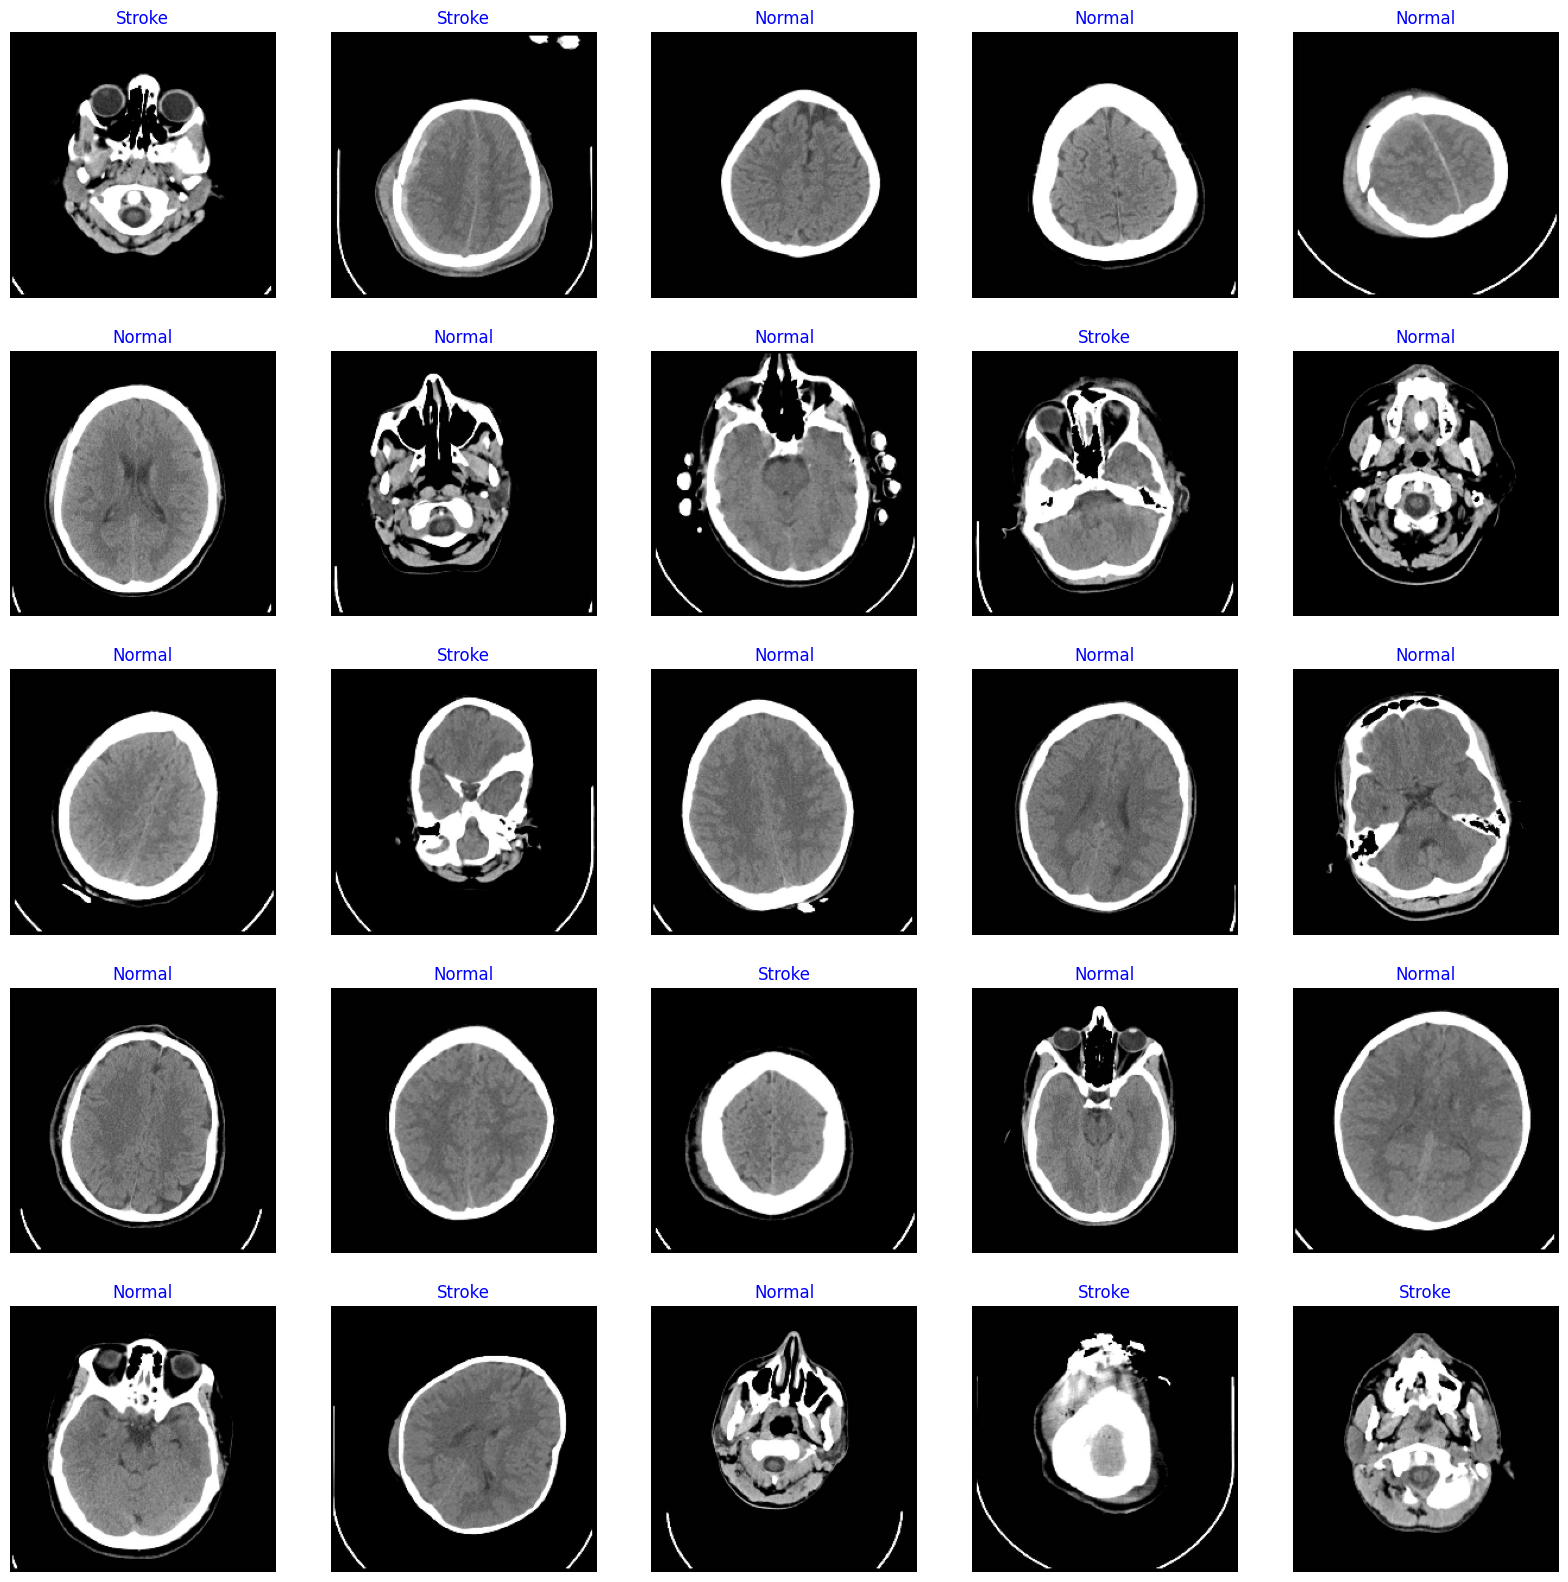

In [ ]:
# Rutas de directorios de conjuntos de datos
train_dir = r'/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Train'
valid_dir = r'/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Validation'
test_dir = r'/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Test'

# Obtener DataFrames
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)

# Obtener generadores de imágenes
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

# Mostrar imágenes de entrenamiento
show_images(train_gen)

# Arquitectura

La arquitectura está inspirada en la conocida red VGG16. El modelo se compone de capas convolucionales, capas de pooling, y capas completamente conectadas. La última capa utiliza la función de activación "softmax" para la clasificación de múltiples clases.

El modelo se compila utilizando el optimizador Adamax, la función de pérdida de entropía cruzada categórica (categorical_crossentropy), y se mide la métrica de precisión (accuracy). El resumen del modelo muestra la estructura de capas y la cantidad de parámetros entrenables en cada capa.

**Capa de Entrada:**
* Tipo de Capa: Conv2D
* Tamaño de Salida: (None, 224, 224, 64)
* Número de Parámetros: 1792
* Descripción: La capa de entrada convolucional (Conv2D) con 64 filtros y un tamaño de kernel de (3, 3). La salida es una imagen con dimensiones (224, 224, 64).

**Bloque 1:**
* Tipo de Capa: Conv2D
* Tamaño de Salida: (None, 224, 224, 64)
* Número de Parámetros: 36928
* Descripción: Otra capa convolucional con 64 filtros y un tamaño de kernel de (3, 3). No hay cambio en las dimensiones de la imagen.
* Tipo de Capa: MaxPooling2D
* Tamaño de Salida: (None, 112, 112, 64)
* Descripción: Una capa de pooling que reduce a la mitad las dimensiones de la imagen mediante un pool de máximo de tamaño (2, 2).

**Bloque 2:**
* Tipo de Capa: Conv2D
* Tamaño de Salida: (None, 112, 112, 128)
* Número de Parámetros: 73856
* Descripción: Capa convolucional con 128 filtros y un tamaño de kernel de (3, 3).
* Tipo de Capa: Conv2D
* Tamaño de Salida: (None, 112, 112, 128)
* Número de Parámetros: 147584
* Descripción: Otra capa convolucional con 128 filtros.
* Tipo de Capa: MaxPooling2D
* Tamaño de Salida: (None, 56, 56, 128)
* Descripción: Capa de pooling que reduce a la mitad las dimensiones de la imagen.

**Bloque 3:**
* ... (Replica el patrón de Bloque 2 pero con 256 filtros)

**Bloque 4:**
* ... (Replica el patrón de Bloque 2 pero con 512 filtros)

**Bloque 5:**
* ... (Replica el patrón de Bloque 2 pero con 512 filtros)

**Capa de Salida:**
* Tipo de Capa: Dense (Totalmente Conectada)
* Tamaño de Salida: (None, 2)
* Número de Parámetros: 21154050
* Descripción: Capa totalmente conectada que produce la salida final con 2 nodos, correspondientes a las clases 'Normal' y 'Stroke'.

**Resumen Adicional:**
* Total de Parámetros: 21154050
* Parámetros Entrenables: 21154050
* Parámetros No Entrenables: 0

Este modelo sigue la arquitectura de la red neuronal convolucional VGG16, que es conocida por su profundidad y capacidad para aprender características complejas de las imágenes. La capa de salida utiliza la función de activación softmax para clasificación multiclase. Es un modelo grande y requiere una cantidad significativa de recursos computacionales para entrenar y evaluar debido al gran número de parámetros.

In [ ]:
# Definición de la estructura del modelo
img_size = (224, 224)  # Tamaño de las imágenes de entrada
channels = 3  # Número de canales de color (RGB)
img_shape = (img_size[0], img_size[1], channels)  # Forma de las imágenes de entrada
class_count = len(list(train_gen.class_indices.keys()))  # Número de clases en el conjunto de datos

# Creación del modelo Sequential
model = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu", input_shape=img_shape),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation="relu"),
    Dense(64, activation="relu"),
    Dense(class_count, activation="softmax")
])

# Compilación del modelo con configuración de optimizador, función de pérdida y métricas
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo mostrando la estructura de capas y parámetros
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [ ]:
# Entrenamiento del modelo
history = model.fit(
    x=train_gen,                    # Datos de entrenamiento
    epochs=40,                      # Número de épocas de entrenamiento
    verbose=1,                      # Nivel de verbosidad durante el entrenamiento (0: silencioso, 1: progreso, 2: detallado)
    validation_data=valid_gen,      # Datos de validación
    validation_steps=None,          # Número de pasos de validación por época (si es None, se calcula automáticamente)
    shuffle=False,                  # Indica si mezclar los datos de entrenamiento en cada época
    initial_epoch=0                 # Época inicial (útil si se reanuda el entrenamiento desde un punto anterior)
)

Epoch 1/40
47/47 [==============================] - 174s 3s/step - loss: 5.9033 - accuracy: 0.5648 - val_loss: 0.6621 - val_accuracy: 0.6681
Epoch 2/40
47/47 [==============================] - 25s 530ms/step - loss: 0.6783 - accuracy: 0.5898 - val_loss: 0.6365 - val_accuracy: 0.6681
Epoch 3/40
47/47 [==============================] - 26s 555ms/step - loss: 0.6778 - accuracy: 0.5898 - val_loss: 0.6410 - val_accuracy: 0.6681
Epoch 4/40
47/47 [==============================] - 26s 554ms/step - loss: 0.6778 - accuracy: 0.5898 - val_loss: 0.6494 - val_accuracy: 0.6681
Epoch 5/40
47/47 [==============================] - 26s 546ms/step - loss: 0.6750 - accuracy: 0.5898 - val_loss: 0.6280 - val_accuracy: 0.6681
Epoch 6/40
47/47 [==============================] - 28s 587ms/step - loss: 0.6601 - accuracy: 0.6012 - val_loss: 0.5897 - val_accuracy: 0.6766
Epoch 7/40
47/47 [==============================] - 27s 574ms/step - loss: 0.6271 - accuracy: 0.6403 - val_loss: 0.5802 - val_accuracy: 0.6851
E

# Visualización

Este código utiliza la función plot_training previamente definida para visualizar las curvas de entrenamiento y validación del modelo a lo largo de las épocas. El objeto history que se pasa como argumento contiene información sobre las métricas y pérdidas calculadas durante el entrenamiento.

La función plot_training grafica la pérdida y la precisión (accuracy) tanto en el conjunto de entrenamiento como en el de validación a lo largo de las épocas. Además, destaca el punto de menor pérdida de validación y el punto de mayor precisión de validación en las respectivas gráficas. La visualización proporciona información valiosa sobre el rendimiento y la convergencia del modelo durante el entrenamiento.

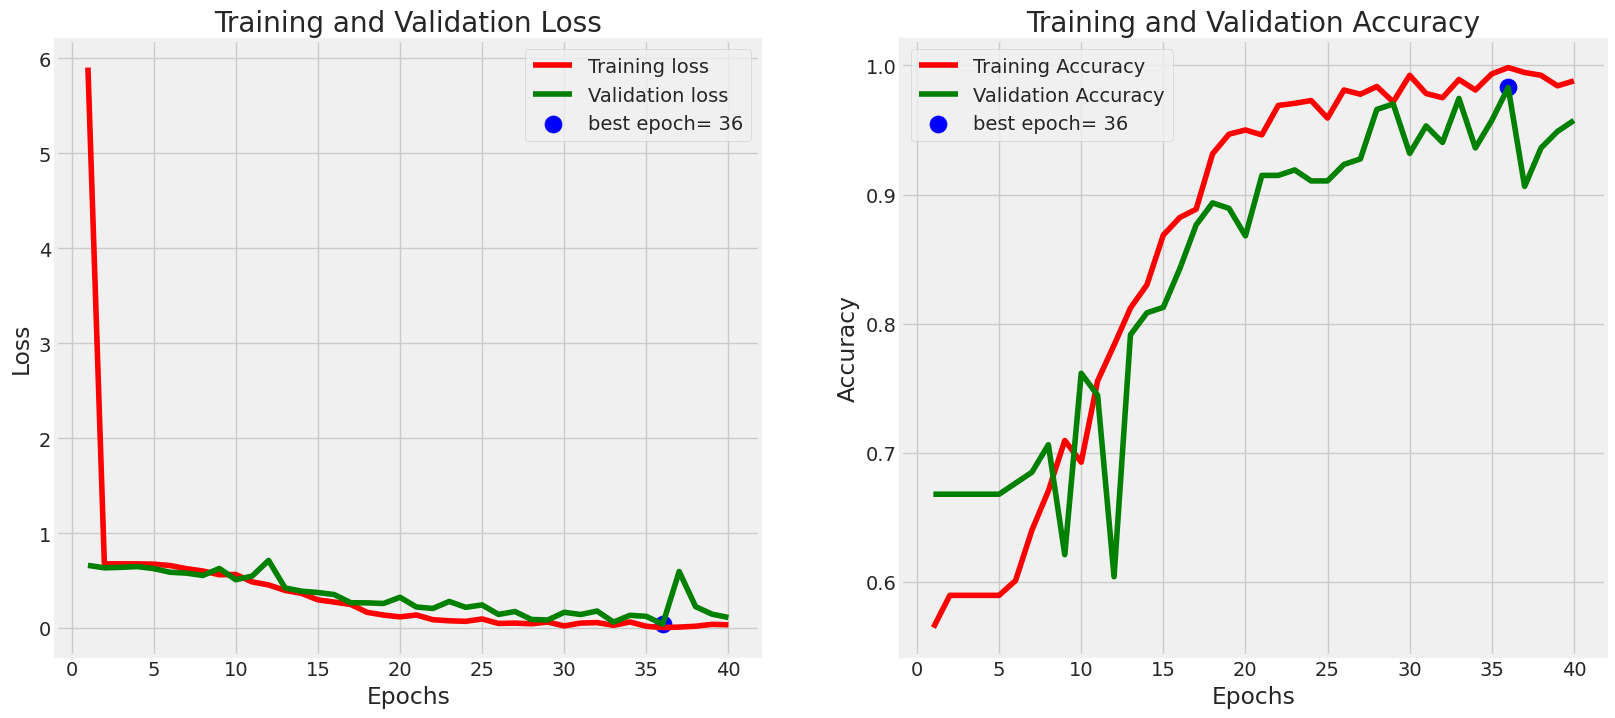

In [ ]:
# Visualización de las curvas de entrenamiento y validación
plot_training(history)

Este código realiza las siguientes acciones:

1. Cálculo del Tamaño del Lote de Prueba: Calcula el tamaño del lote(test_batch_size) para el conjunto de prueba de manera que sea menor o igual al 80% del tamaño total del conjunto de prueba.

2. Cálculo de Pasos de Prueba: Calcula el número de pasos (test_steps) necesarios para evaluar el modelo en el conjunto de prueba.

3. Evaluación del Modelo en Conjuntos de Datos: Utiliza el método evaluate para obtener las métricas de pérdida y precisión del modelo en los conjuntos de entrenamiento, validación y prueba.

4. Mostrar Métricas de Evaluación: Imprime las métricas de pérdida y precisión en los conjuntos de entrenamiento, validación y prueba.

Estas métricas proporcionan una evaluación cuantitativa del rendimiento del modelo en diferentes conjuntos de datos, lo que es útil para comprender su capacidad para generalizar a nuevos datos no vistos durante el entrenamiento.

In [ ]:
# Calcular el tamaño del lote para el conjunto de prueba
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))

# Calcular el número de pasos para el conjunto de prueba
test_steps = ts_length // test_batch_size

# Evaluar el modelo en los conjuntos de entrenamiento, validación y prueba
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

# Mostrar las métricas de evaluación
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

 6/19 [========>.....................] - ETA: 2s - loss: 0.1134 - accuracy: 0.9574

19/19 [==============================] - 58s 3s/step - loss: 0.1112 - accuracy: 0.9565
Train Loss:  0.029382605105638504
Train Accuracy:  0.9842105507850647
--------------------
Validation Loss:  0.11335333436727524
Validation Accuracy:  0.957446813583374
--------------------
Test Loss:  0.11123836040496826
Test Accuracy:  0.95652174949646


**Resultados durante el Entrenamiento:**

19/19 [==============================] - 4s 184ms/step - loss: 0.0294 - accuracy: 0.9842
* La primera línea muestra el progreso durante una época del entrenamiento. "19/19" indica que el modelo ha completado 19 pasos de entrenamiento en una época. Cada paso representa una actualización de los pesos del modelo utilizando un lote de datos.
* "4s" indica que ha tomado aproximadamente 4 segundos completar la época.
* "184ms/step" indica el tiempo promedio que tarda cada paso de entrenamiento.
* "loss: 0.0294" es la pérdida promedio en el conjunto de entrenamiento después de la época.
* "accuracy: 0.9842" es la precisión promedio en el conjunto de entrenamiento después de la época.

**Resultados durante la Validación:**

6/19 [========>.....................] - ETA: 2s - loss: 0.1134 - accuracy: 0.9574
* Estas líneas muestran el progreso durante la validación después de una época de entrenamiento. "6/19" indica que se han completado 6 pasos de validación de un total de 19 pasos previstos.
* "ETA: 2s" indica que se espera que la validación se complete en aproximadamente 2 segundos.
* "loss: 0.1134" es la pérdida promedio en el conjunto de validación después de la época.
* "accuracy: 0.9574" es la precisión promedio en el conjunto de validación después de la época.
* La advertencia "Your input ran out of data; interrupting training..." indica que la cantidad de datos disponibles para la validación no es suficiente para completar todos los pasos planificados.

**Resultados después del Entrenamiento y Evaluación:**

19/19 [==============================] - 58s 3s/step - loss: 0.1112 - accuracy: 0.9565
* Estas líneas muestran los resultados finales después de que se completaron todas las épocas de entrenamiento.
* "loss: 0.1112" es la pérdida final en el conjunto de prueba.
* "accuracy: 0.9565" es la precisión final en el conjunto de prueba.

**Resumen Final:**
* Train Loss: 0.0294
* Train Accuracy: 0.9842
* Validation Loss: 0.1134
* Validation Accuracy: 0.9574
* Test Loss: 0.1112
* Test Accuracy: 0.9565

Estos valores proporcionan una evaluación del rendimiento del modelo en los conjuntos de entrenamiento, validación y prueba después de completar el entrenamiento. Una pérdida más baja y una precisión más alta son generalmente indicativos de un mejor rendimiento del modelo. En este caso, el modelo parece tener un rendimiento bastante bueno, con una alta precisión tanto en el conjunto de entrenamiento como en el de prueba.

Este código realiza las siguientes acciones:

1. Generar Predicciones: Utiliza el método predict_generator para generar predicciones utilizando el modelo en el conjunto de prueba (test_gen). El resultado (preds) es un array que contiene las probabilidades predichas para cada clase en cada muestra del conjunto de prueba.

2. Obtener Clases Predichas: Utiliza la función np.argmax para obtener las clases predichas (y_pred). En cada fila de preds, encuentra el índice de la clase con la probabilidad más alta. Estos índices representan las clases predichas para cada muestra en el conjunto de prueba.

Estas predicciones pueden ser utilizadas para evaluar la calidad del modelo en el conjunto de prueba y compararlas con las etiquetas reales para calcular métricas de rendimiento como la matriz de confusión, la precisión, el recall, etc.

In [ ]:
# Generar predicciones utilizando el modelo en el conjunto de prueba
preds = model.predict_generator(test_gen)

# Obtener las clases predichas (índices de las clases con mayor probabilidad)
y_pred = np.argmax(preds, axis=1)

Este código realiza las siguientes acciones:

1. Definir Nombres de Clases: Crea una lista target_names que contiene los nombres de las clases o etiquetas del problema de clasificación (en este caso, 'Normal' y 'Stroke').

2. Matriz de Confusión: Utiliza la función confusion_matrix de scikit-learn para calcular la matriz de confusión (cm). La matriz de confusión compara las etiquetas reales del conjunto de prueba (test_gen.classes) con las clases predichas (y_pred).

3. Visualizar la Matriz de Confusión: Utiliza la función previamente definida plot_confusion_matrix para visualizar la matriz de confusión. Esto proporciona una representación gráfica de cómo el modelo clasifica las muestras en las diferentes clases.

4. Informe de Clasificación: Utiliza la función classification_report de scikit-learn para imprimir un informe de clasificación. El informe incluye métricas como precisión, recall, y F1-score para cada clase, así como métricas agregadas.

Estas visualizaciones y métricas son útiles para evaluar el rendimiento del modelo en la clasificación de las clases y comprender su capacidad para distinguir entre las clases objetivo.

Confusion Matrix, Without Normalization
[[302   5]
 [ 14 116]]
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97       307
      Stroke       0.96      0.89      0.92       130

    accuracy                           0.96       437
   macro avg       0.96      0.94      0.95       437
weighted avg       0.96      0.96      0.96       437



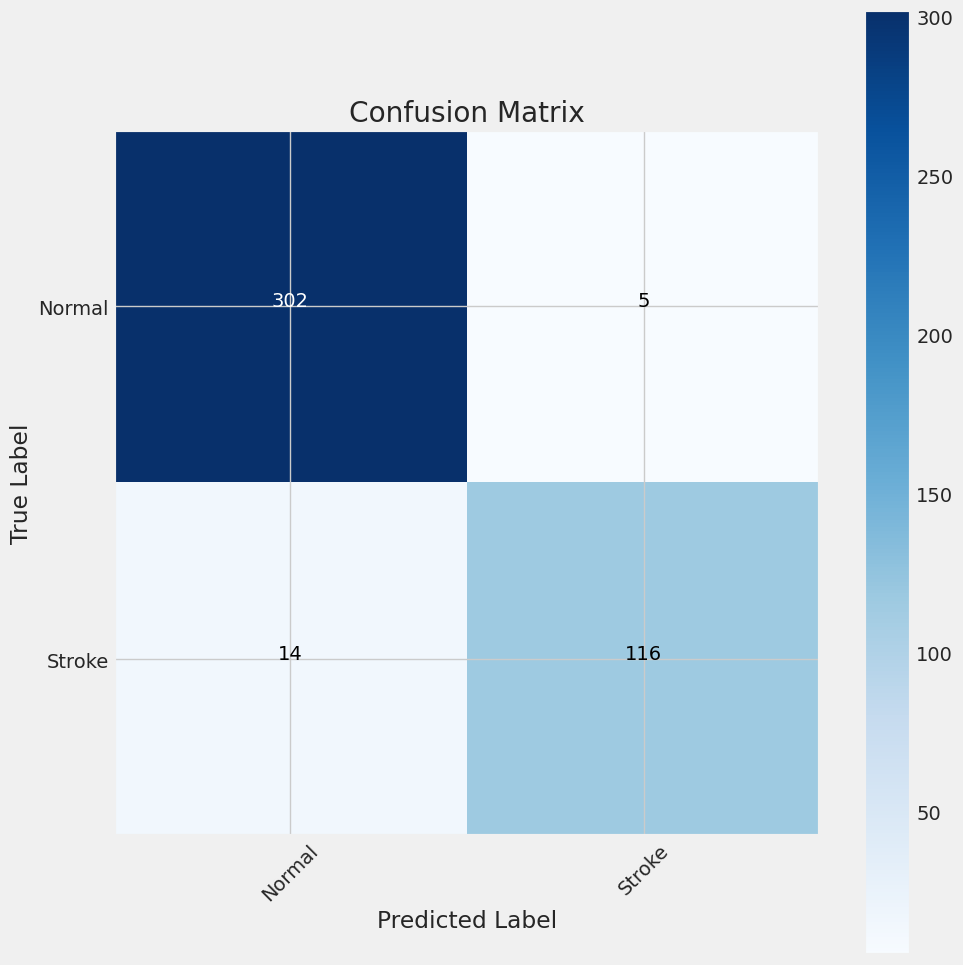

In [ ]:
# Definir nombres de clases (etiquetas)
target_names = ['Normal', 'Stroke']

# Matriz de confusión
cm = confusion_matrix(test_gen.classes, y_pred)

# Visualizar la matriz de confusión
plot_confusion_matrix(cm=cm, classes=target_names, title='Confusion Matrix')

# Informe de clasificación
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

**Matriz de Confusión:**

[[302 5]
[ 14 116]]

* La matriz muestra las predicciones del modelo comparadas con las clases reales. En este caso, hay dos clases: 'Normal' y 'Stroke'.
* Los números en la diagonal principal (302 y 116) son las predicciones correctas. Por ejemplo, el modelo clasificó correctamente 302 muestras como 'Normal' y 116 muestras como 'Stroke'.
* Los números fuera de la diagonal principal son los errores de predicción. Por ejemplo, el modelo clasificó erróneamente 5 muestras que eran 'Normal' como 'Stroke' y 14 muestras que eran 'Stroke' como 'Normal'.

**Informe de Clasificación:**

* precision recall f1-score support

  * Normal 0.96 0.98 0.97 307

  * Precision: De las muestras que el modelo clasificó como 'Normal', el 96% realmente pertenecían a la clase 'Normal'.
  * Recall: De todas las muestras que son realmente 'Normal', el 98% fueron correctamente clasificadas por el modelo.
  * F1-score: Una métrica que combina precisión y recall en un solo número, útil cuando las clases están desequilibradas.
  * Support: La cantidad real de muestras en la clase 'Normal'.

* Stroke 0.96 0.89 0.92 130
  * Precision: De las muestras que el modelo clasificó como 'Stroke', el 96% realmente pertenecían a la clase 'Stroke'.
  * Recall: De todas las muestras que son realmente 'Stroke', el 89% fueron correctamente clasificadas por el modelo.
  * F1-score: Una métrica que combina precisión y recall en un solo número, útil cuando las clases están desequilibradas.
  * Support: La cantidad real de muestras en la clase 'Stroke'.

* accuracy 0.96 437
  * La precisión global del modelo en todas las clases combinadas. En este caso, es del 96%.

* macro avg 0.96 0.94 0.95 437
  *Promedio macro de precision, recall y f1-score. El macro avg da el mismo peso a cada clase, independientemente del tamaño de la clase.

* weighted avg 0.96 0.96 0.96 437
  * Promedio ponderado de precision, recall y f1-score. El weighted avg tiene en cuenta el desequilibrio en el número de muestras en cada clase.

En resumen, el modelo parece tener un rendimiento bastante bueno, con altas precisiones, recalls y f1-scores en ambas clases. Sin embargo, como siempre, la interpretación debe hacerse teniendo en cuenta el contexto del problema y las necesidades específicas del usuario.

In [ ]:
#Guardar modelo
model.save('EVC_P4.h5')

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/EVC_P4.h5')

1/1 [==============================] - 0s 83ms/step


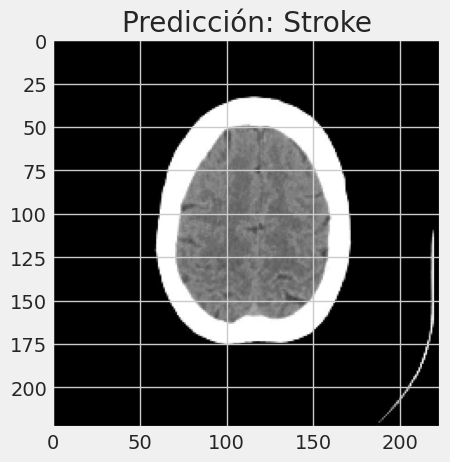

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que tienes una nueva imagen que deseas clasificar
new_image_path = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Test/Normal/103 (32).jpg'

# Cargar y preprocesar la imagen
img = image.load_img(new_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalizar la imagen

# Hacer predicciones
predictions = loaded_model.predict(img_array)
class_index = np.argmax(predictions[0])
class_name = target_names[class_index]

# Mostrar la imagen junto con la predicción
plt.imshow(img)
plt.title(f'Predicción: {class_name}')
plt.show()
